# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [5]:
train_X

array([[-0.08975373, -0.03568431,  0.08994824, ..., -0.03998549,
         0.09710392,  1.        ],
       [ 0.01612863,  0.01921765,  0.05465412, ..., -0.13410314,
        -0.10681765,  1.        ],
       [-0.25445961, -0.32980196, -0.36887529, ..., -0.20469137,
        -0.23230784,  1.        ],
       ...,
       [ 0.38083451,  0.36823725,  0.36053647, ...,  0.23060275,
         0.21867255,  1.        ],
       [-0.2426949 , -0.22391961, -0.12965961, ..., -0.14194627,
        -0.13034706,  1.        ],
       [ 0.01220706,  0.02706078,  0.18798745, ...,  0.06981843,
         0.10886863,  1.        ]])

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [6]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check
from gradient_check import check_gradient

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
import linear_classifer
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [9]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [10]:
import linear_classifer
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [11]:
import linear_classifer

batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [14]:
import linear_classifer
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [30]:
import linear_classifer

classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.397687
Epoch 1, loss: 2.330513
Epoch 2, loss: 2.311144
Epoch 3, loss: 2.304570
Epoch 4, loss: 2.303160
Epoch 5, loss: 2.303056
Epoch 6, loss: 2.301780
Epoch 7, loss: 2.302396
Epoch 8, loss: 2.301589
Epoch 9, loss: 2.300945


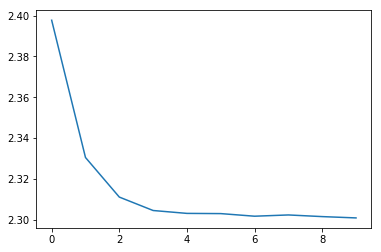

In [31]:
# let's look at the loss history!
plt.plot(loss_history)

In [32]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.125
Epoch 0, loss: 2.301629
Epoch 1, loss: 2.301919
Epoch 2, loss: 2.302523
Epoch 3, loss: 2.301311
Epoch 4, loss: 2.302054
Epoch 5, loss: 2.302173
Epoch 6, loss: 2.302712
Epoch 7, loss: 2.302095
Epoch 8, loss: 2.302179
Epoch 9, loss: 2.302007
Epoch 10, loss: 2.301464
Epoch 11, loss: 2.301976
Epoch 12, loss: 2.301795
Epoch 13, loss: 2.301439
Epoch 14, loss: 2.302229
Epoch 15, loss: 2.302286
Epoch 16, loss: 2.303321
Epoch 17, loss: 2.302511
Epoch 18, loss: 2.302486
Epoch 19, loss: 2.302873
Epoch 20, loss: 2.301801
Epoch 21, loss: 2.301355
Epoch 22, loss: 2.301825
Epoch 23, loss: 2.302187
Epoch 24, loss: 2.302101
Epoch 25, loss: 2.302480
Epoch 26, loss: 2.302529
Epoch 27, loss: 2.301585
Epoch 28, loss: 2.301976
Epoch 29, loss: 2.301327
Epoch 30, loss: 2.301778
Epoch 31, loss: 2.301380
Epoch 32, loss: 2.302286
Epoch 33, loss: 2.302310
Epoch 34, loss: 2.301027
Epoch 35, loss: 2.302436
Epoch 36, loss: 2.301471
Epoch 37, loss: 2.302226
Epoch 38, loss: 2.301985
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [79]:
from sklearn.model_selection import GridSearchCV
import linear_classifer


In [93]:
num_epochs = 10
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

        
best_classifier = None
best_val_accuracy = None
parameters = {'learning_rate': learning_rates, 
              'reg': reg_strengths,
              'epochs': [num_epochs],
              'batch_size': [batch_size]
             }
clf = linear_classifer.LinearSoftmaxClassifier()
gscv = GridSearchCV(clf, parameters, cv=5)
gscv.fit(train_X, train_y)

#print('best validation accuracy achieved: %f' % best_val_accuracy)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSoftmaxClassifier(batch_size=100, epochs=1, learning_rate=1e-07,
            reg=1e-05),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.001, 0.0001, 1e-05], 'reg': [0.0001, 1e-05, 1e-06], 'epochs': [10], 'batch_size': [300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
gscv.best_score_

0.16433333333333333

In [97]:
from sklearn.model_selection import KFold

num_epochs = 10
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]


best_classifier = None
best_val_accuracy = -1

# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds = []
test_folds = []
l_r_to_accuracy = {}

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

kf = KFold(num_folds, shuffle=True)

for train, test in kfold.split(train_X):
    train_folds.append(train)
    test_folds.append(test)  

for l in learning_rates:
    for r in reg_strengths:
        fix_l_r_accuracy = []
        
        classifier = linear_classifer.LinearSoftmaxClassifier(
            epochs=num_epochs, 
            learning_rate=l, 
            batch_size=batch_size, 
            reg=r)
        for i, train in enumerate(train_folds_X):
            loss_history = classifier.fit(train_X[train], train_y[train])
            pred = classifier.predict(train_X[test_folds_X[i]])
            accuracy = multiclass_accuracy(pred, train_y[test_folds_X[i]])
            fix_l_r_accuracy.append(accuracy)

        l_r_to_accuracy[str(l) + ', ' + str(r)] = np.average(fix_l_r_accuracy)
        print("Linear classifier with l = %e and r = %e" % (l, r))
        print("Accuracy: %4.2f" % (l_r_to_accuracy[str(l) + ', ' + str(r)])) 
        if l_r_to_accuracy[str(l) + ', ' + str(r)] > best_val_accuracy:
            best_val_accuracy = l_r_to_accuracy[str(l) + ', ' + str(r)]
            best_classifier = classifier

for lr in sorted(l_r_to_accuracy):
    print('l, r = %s, accuracy = %f' % (lr, l_r_to_accuracy[lr]))

Linear classifier with l = 1.000000e-03 and r = 1.000000e-04
Accuracy: 0.20
Linear classifier with l = 1.000000e-03 and r = 1.000000e-05
Accuracy: 0.19
Linear classifier with l = 1.000000e-03 and r = 1.000000e-06
Accuracy: 0.20
Linear classifier with l = 1.000000e-04 and r = 1.000000e-04
Accuracy: 0.14
Linear classifier with l = 1.000000e-04 and r = 1.000000e-05
Accuracy: 0.14
Linear classifier with l = 1.000000e-04 and r = 1.000000e-06
Accuracy: 0.13
Linear classifier with l = 1.000000e-05 and r = 1.000000e-04
Accuracy: 0.10
Linear classifier with l = 1.000000e-05 and r = 1.000000e-05
Accuracy: 0.10
Linear classifier with l = 1.000000e-05 and r = 1.000000e-06
Accuracy: 0.10
l, r = 0.0001, 0.0001, accuracy = 0.139667
l, r = 0.0001, 1e-05, accuracy = 0.140000
l, r = 0.0001, 1e-06, accuracy = 0.130222
l, r = 0.001, 0.0001, accuracy = 0.196444
l, r = 0.001, 1e-05, accuracy = 0.192778
l, r = 0.001, 1e-06, accuracy = 0.196000
l, r = 1e-05, 0.0001, accuracy = 0.099889
l, r = 1e-05, 1e-05, ac

# Какой же точности мы добились на тестовых данных?

In [85]:
test_pred = gscv.best_estimator_.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.184000


In [98]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.163000
